In [1]:
%load_ext jupyter_black

# Libraries
import json
import csv
import pandas as pd
import os
import re

import requests
from PIL import Image

from ollama import chat
from ollama import ChatResponse
import base64
from io import BytesIO

from tqdm.notebook import tqdm

# for showing image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

In [ ]:
# set target dataset and file locations
target_caption_dataset_filename = "./data/caption-dataset/annotations/train.json"
image_folder = "./data/clean-images"
filenames = next(os.walk(image_folder), (None, None, []))[2]

# get image quality annotations
target_image_quality_dataset_filename = (
    "./data/image-quality-assessment/annotations/train.json"
)

In [ ]:
# get images and annotations in one dataframe
image_annotation_df = None
with open(target_caption_dataset_filename) as f:
    # load caption dataset
    caption_dataset_json = json.load(f)

    # combine image files and annotations
    images_df = pd.DataFrame.from_dict(caption_dataset_json["images"])
    annotations_df = pd.DataFrame.from_dict(caption_dataset_json["annotations"])
    grouped_annotations = (
        annotations_df.groupby(["image_id"]).agg(tuple).map(list).reset_index()
    )
    image_annotation_df = images_df.merge(
        grouped_annotations[["image_id", "caption", "is_precanned", "is_rejected"]],
        left_on="id",
        right_on="image_id",
    )

    # vizwiz_url is broken, so fix with https://vizwiz.cs.colorado.edu/*
    image_annotation_df["vizwiz_url"] = image_annotation_df["vizwiz_url"].apply(
        lambda x: x.replace(
            "https://ivc.ischool.utexas.edu/", "https://vizwiz.cs.colorado.edu/"
        )
    )


image_annotation_df

In [ ]:
# get image quality
image_quality_annotation_df = None
with open(target_image_quality_dataset_filename) as f:
    # load image quality annotation dataset
    image_quality_dataset_json = json.load(f)
    image_quality_df = pd.DataFrame.from_dict(image_quality_dataset_json)

    # expand object of flaws into individual columns and rename
    image_quality_df = pd.concat(
        [
            image_quality_df.drop(["flaws"], axis=1),
            pd.json_normalize(image_quality_df["flaws"]),
        ],
        axis=1,
    )
    image_quality_df.rename(
        columns={
            "FRM": "framing",
            "BLR": "blur",
            "DRK": "too dark",
            "BRT": "too bright",
            "OBS": "obstruction",
            "OTH": "other",
            "NON": "no issue",
            "ROT": "rotation",
        },
        inplace=True,
    )

image_quality_df

In [ ]:
# combine image and quality datasets together
image_captioning_input = image_annotation_df.merge(
    image_quality_df, left_on="file_name", right_on="image"
).drop(["image"], axis=1)

In [ ]:
# filter input for only the selected clean images
filtered_images_df = image_captioning_input.query("file_name.isin(@filenames)")
filtered_images_df["model_caption"] = ""
dataset_to_caption = filtered_images_df.to_dict("records")

filtered_images_df

In [ ]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])

    # generate output and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [image_file],
            },
        ],
    )
    dataset_to_caption[index]["model_caption"] = response["message"]["content"]

## Testing Defocus Blur before captioning
[Defocus](https://albumentations.ai/docs/api_reference/augmentations/blur/transforms/#albumentations.augmentations.blur.transforms.Defocus) blur simulates out-of-focus cameras (which can happen if a BLV person is taking a picture) by applying both a disc kernal and Gaussian blur to the image. The blur is specified by 3 parameters:
- `radius (tuple[int, int], int)`: Range for the radius of the defocus blur. If a single int is provided, the range will be [1, radius]. Larger values create a stronger blur effect. **I use 10, 20, 30 to correspond to light, medium, and heavy blurring for now; this is set as [radius, radius] so the blurring is consistent. Heavy blurring does not make the image illegible to a human.**
- `alias_blur (tuple[float, float] | float)`: Range for the standard deviation of the Gaussian blur applied after the main defocus blur. This helps to reduce aliasing artifacts. If a single float is provided, the range will be (0, alias_blur). Larger values create a smoother, more aliased effect. **I fix this to (0.4, 0.4) so a consistent amount of blur is always applied.**
- `p (float)`: probability of applying transform. This is used in a data augmentation pipeline where one wants to try various combinations of transformations during training / evaluation. **Since we always want a blur, `p = 1.0` below**

The defocus effect is created using a disc kernel, which simulates the shape of a camera's aperture, with a larger `radius` causing a more noticable defocusing effect. The Gaussian blur specified by `alias_blur` helps to soften the edges of the disc kernel, creating a more natural-looking defocus effect.

In [ ]:
import albumentations as A
import numpy as np


def pil_to_base64(pil_image):
    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    return base64.b64encode(im_bytes).decode("utf-8")

### Testing blur settings

In [ ]:
# set-up a plot to show the images
rcParams["figure.figsize"] = 16, 8
fig, ax = plt.subplots(1, 4)
plt_counter = 0

# show original image
pillow_image = Image.open(
    os.path.join(image_folder, dataset_to_caption[4]["file_name"])
)
ax[plt_counter].imshow(pillow_image)
plt_counter += 1

# apply varying levels of defocus
disc_blur_settings = [10, 15, 20]
image_np = np.array(pillow_image)
for setting in disc_blur_settings:
    blur_transform = A.Compose(
        [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
    )
    blurred_image_np = blur_transform(image=image_np)["image"]
    blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")
    ax[plt_counter].imshow(blurred_image_pil)
    plt_counter += 1

In [ ]:
# add placeholder for blurred captions
for item in dataset_to_caption:
    item["low_blur_model_caption"] = ""
    item["med_blur_model_caption"] = ""
    item["high_blur_model_caption"] = ""

In [ ]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])

    # generate output for each blur
    # show original image
    pillow_image = Image.open(image_file)

    # apply varying levels of defocus
    disc_blur_settings = [
        ("low_blur_model_caption", 10),
        ("med_blur_model_caption", 15),
        ("high_blur_model_caption", 20),
    ]
    image_np = np.array(pillow_image)
    for key, setting in disc_blur_settings:
        blur_transform = A.Compose(
            [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
        )
        blurred_image_np = blur_transform(image=image_np)["image"]
        blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")

        # generate output and store in dict
        response: ChatResponse = chat(
            model="llama3.2-vision",
            messages=[
                system_prompt,
                {
                    "role": "user",
                    "content": "Can you please tell me what is in this image?",
                    "images": [pil_to_base64(blurred_image_pil)],
                },
            ],
        )
        dataset_to_caption[index][key] = response["message"]["content"]

In [ ]:
# expand human captions into separate columns
output_dataset = json.loads(json.dumps(dataset_to_caption))
for index, item in enumerate(output_dataset):
    if type(item["caption"]) == str:
        item["caption"] = [
            x.strip()
            for x in re.split(
                r'(["\'])(.*?)\1', item["caption"].replace("[", "").replace("]", "")
            )
            if x.strip() != ""
            and x.strip() != ","
            and x.strip() != "'"
            and x.strip() != '"'
        ]
    output_dataset[index]["human_caption_1"] = item["caption"][0]
    output_dataset[index]["human_caption_2"] = item["caption"][1]
    output_dataset[index]["human_caption_3"] = item["caption"][2]
    output_dataset[index]["human_caption_4"] = item["caption"][3]
    output_dataset[index]["human_caption_5"] = item["caption"][4]
    del output_dataset[index]["caption"]

In [ ]:
# move model captions to end of data frame
output_df = pd.DataFrame.from_dict(output_dataset)
for col in [
    "model_caption",
    "low_blur_model_caption",
    "med_blur_model_caption",
    "high_blur_model_caption",
]:
    output_df.insert(len(output_df.columns) - 1, col, output_df.pop(col))
output_df.insert(0, "id", output_df.pop("id"))

# add a note column
output_df["notes (include initials, e.g. 'KG: ...')"] = ""

# rename columns
output_df.rename(columns={"id": "vizwiz_id"}, inplace=True)

# save file
output_df.to_csv(
    "./data/labeled-data/blurred-image-experiment_02-04-25.csv", index=False
)

# print dataframe
output_df.head()

## Testing Privacy Modifications On Image Labeling
VizWiz has a privacy dataset where private portions of images are obscured with a single color representing the mean-color of the dataset, or some of the selected private content overlaid on it; see the [Visual Privacy Challenge](https://vizwiz.org/tasks-and-datasets/vizwiz-priv/). The output dataframe will have 2 images captioned:
1. `mean_image` is the private content obscured with the mean color.
2. `filled_image` is the private content obscured with the image content.

The following example groups are selected:
1. Food: images of food, like cans / bottles of soda and granola boxes. Note that the private content is **not** the food itself, but something else in the image.
2. Login screens: screens asking for login information.
3. Mail / credit cards: pictures that have the image taker's address or credit card information.
4. Medicine: pill bottles that obsecure patient information.
5. People: images with people. Some include background scenes that might be useful to label (e.g., a church).

Due to the private nature of some images (e.g., credit cards), clean images are not available for most examples selected below.

In [ ]:
# load images
mean_fill_image_folder = "./data/privacy-images/mean-pixel"
image_fill_image_folder = "./data/privacy-images/image-fill"
input_dict = {}

for subdir in next(os.walk(mean_fill_image_folder), ([], [], []))[1]:
    filename = next(os.walk(mean_fill_image_folder + "/" + subdir), ([], [], []))[2]

    for file in filename:
        name_without_extension, _ = os.path.splitext(file)
        input_dict[name_without_extension] = {
            "image_type": subdir,
            "mean_fill_filepath": mean_fill_image_folder + "/" + subdir + "/" + file,
            "image_fill_filepath": "",
            "mean_fill_caption": "",
            "image_fill_caption": "",
            "notes (include initials, e.g. 'KG: ...')": "",
        }

for subdir in next(os.walk(image_fill_image_folder), ([], [], []))[1]:
    filename = next(os.walk(image_fill_image_folder + "/" + subdir), ([], [], []))[2]

    for file in filename:
        name_without_extension, _ = os.path.splitext(file)
        if name_without_extension in input_dict:
            input_dict[name_without_extension]["image_fill_filepath"] = (
                image_fill_image_folder + "/" + subdir + "/" + file
            )
            input_dict[name_without_extension]["image_fill_caption"] = ""

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

In [ ]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    mean_fill_image_file = row["mean_fill_filepath"]
    image_fill_image_file = row["image_fill_filepath"]

    # load each image
    mean_fill_pillow_image = Image.open(mean_fill_image_file)
    image_fill_pillow_image = Image.open(image_fill_image_file)

    # generate output for mean fill image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(mean_fill_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["mean_fill_caption"] = response["message"]["content"]

    # generate output for image fill image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(image_fill_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["image_fill_caption"] = response["message"]["content"]

In [ ]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["image_type", "name"], inplace=True)

# save file
output_df.to_csv(
    "./data/labeled-data/privacy-image-experiment_02-11-25.csv", index=False
)

# print dataframe
output_df.head()

## Testing Obscured Images
Images taken by BLV people may have parts obscured by hands or other objects, or be mis-framed. This part of the notebook examines the effects of these obscurations on image captioning.

In [ ]:
# load images
clean_image_folder = "./data/obscured-images/clean-images"
cropped_image_folder = "./data/obscured-images/cropped-images"
obscured_image_folder = "./data/obscured-images/obscured-images"
input_dict = {}

# for subdir in next(os.walk(clean_image_folder), ([], [], []))[1]:
#     print(subdir)
#     filename = next(os.walk(clean_image_folder + "/" + subdir), ([], [], []))[2]

for file in next(os.walk(clean_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    input_dict[name_without_extension] = {
        "clean_image_filepath": clean_image_folder + "/" + file,
        "cropped_image_filepath": "",
        "obscured_image_filepath": "",
        "clean_image_caption": "",
        "cropped_image_caption": "",
        "obscured_image_caption": "",
        "notes (include initials, e.g. 'KG: ...')": "",
    }

for file in next(os.walk(cropped_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    if name_without_extension in input_dict:
        input_dict[name_without_extension]["cropped_image_filepath"] = (
            cropped_image_folder + "/" + file
        )

for file in next(os.walk(obscured_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    if name_without_extension in input_dict:
        input_dict[name_without_extension]["obscured_image_filepath"] = (
            obscured_image_folder + "/" + file
        )

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

In [ ]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    clean_image_file = row["clean_image_filepath"]
    cropped_image_file = row["cropped_image_filepath"]
    obscured_image_file = row["obscured_image_filepath"]

    # load each image
    clean_pillow_image = Image.open(clean_image_file)
    cropped_pillow_image = Image.open(cropped_image_file)
    obscured_pillow_image = Image.open(obscured_image_file)

    # generate output for clean image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(clean_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["clean_image_caption"] = response["message"]["content"]

    # generate output for cropped image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(cropped_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["cropped_image_caption"] = response["message"]["content"]

    # generate output for obscured image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(obscured_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["obscured_image_caption"] = response["message"]["content"]

In [ ]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["name"], inplace=True)

# save file
output_df.to_csv(
    "./data/labeled-data/obscured-image-experiment_02-11-25.csv", index=False
)

# print dataframe
output_df.head()

## Testing Rotated Images
Images taken by BLV people may not be oriented in expected ways. For example, a bottle of condiments could be held upside down. We hypothesize that this can cause issues with VLMs since their training data is likely on well-framed and oriented images. Below, we analyze 3 cases:
1. Little text images, such as text labels on a remote
2. Medium text images, such as a can of food or a bag of chips
3. Heavy text images, such as a nutritional label.
The hypothesis is that heavier text images are more likely to be affected by rotations when captioning.

Two types of rotation are applied:
1. 90 degree rotation, which corresponds to an image taken vertically when intended to be taken horizontally
2. 180 degree rotation, which corresponds to the object in an image being flipped

In [2]:
import albumentations as A
import numpy as np


def pil_to_base64(pil_image):
    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    return base64.b64encode(im_bytes).decode("utf-8")

/Users/kgarg/.local/share/virtualenvs/local-blurred-captioning-exploration-4LZKhcfn/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# load images
light_text_image_folder = "./data/rotation-experiment-images/light-text-images"
medium_text_image_folder = "./data/rotation-experiment-images/medium-text-images"
heavy_text_image_folder = "./data/rotation-experiment-images/heavy-text-images"
input_dict = {}

all_files = [
    next(os.walk(light_text_image_folder), ([], [], [])),
    next(os.walk(medium_text_image_folder), ([], [], [])),
    next(os.walk(heavy_text_image_folder), ([], [], [])),
]

for directory in all_files:
    image_type = (
        directory[0].split("./data/rotation-experiment-images/")[1].replace("-", " ")
    )
    for file in directory[2]:
        name_without_extension, _ = os.path.splitext(file)
        input_dict[name_without_extension] = {
            "type": image_type,
            "image_filepath": directory[0] + "/" + file,
            "original_image_caption": "",
            "rotation_90_image_caption": "",
            "rotation_180_image_caption": "",
            "notes (include initials, e.g. 'KG: ...')": "",
        }

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

,name,type,image_filepath,original_image_caption,rotation_90_image_caption,rotation_180_image_caption,"notes (include initials, e.g. 'KG: ...')"
0,VizWiz_train_00000267,light text images,./data/rotation-experiment-images/light-text-i...,,,,
1,VizWiz_train_00000012,light text images,./data/rotation-experiment-images/light-text-i...,,,,
2,VizWiz_train_00000417,light text images,./data/rotation-experiment-images/light-text-i...,,,,
3,VizWiz_train_00000124,light text images,./data/rotation-experiment-images/light-text-i...,,,,
4,VizWiz_train_00000111,medium text images,./data/rotation-experiment-images/medium-text-...,,,,
5,VizWiz_train_00000006,medium text images,./data/rotation-experiment-images/medium-text-...,,,,
6,VizWiz_train_00000171,medium text images,./data/rotation-experiment-images/medium-text-...,,,,
7,VizWiz_train_00000252,medium text images,./data/rotation-experiment-images/medium-text-...,,,,
8,VizWiz_train_00000339,heavy text images,./data/rotation-experiment-images/heavy-text-i...,,,,
9,VizWiz_train_00000165,heavy text images,./data/rotation-experiment-images/heavy-text-i...,,,,


### Testing Rotation settings

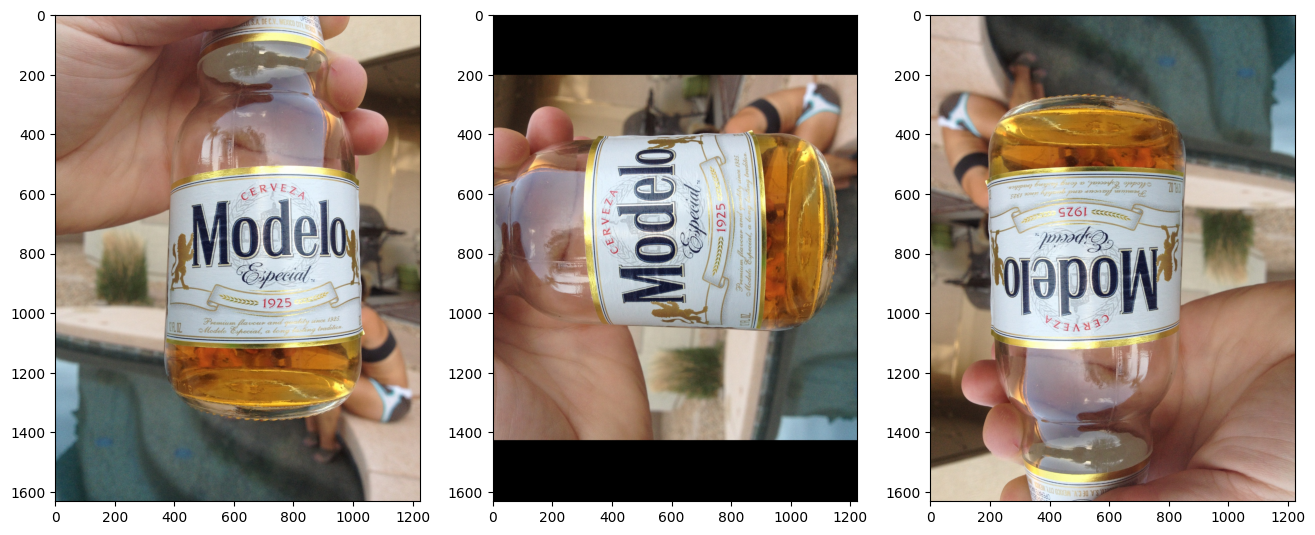

In [8]:
# set-up a plot to show the images
rcParams["figure.figsize"] = 16, 8
fig, ax = plt.subplots(1, 3)
plt_counter = 0

# show original image
pillow_image = Image.open(dataset_to_caption[4]["image_filepath"])
ax[plt_counter].imshow(pillow_image)
plt_counter += 1

# apply varying levels of defocus
rotation_settings = [90, 180]
image_np = np.array(pillow_image)
for setting in rotation_settings:
    rotation_transform = A.Rotate(limit=(setting, setting), p=1.0)
    rotation_result_np = rotation_transform(image=image_np)["image"]
    rotation_result_pil = Image.fromarray(np.uint8(rotation_result_np)).convert("RGB")
    ax[plt_counter].imshow(rotation_result_pil)
    plt_counter += 1

In [4]:
# model prompt
system_prompt = {
    "role": "system",
    "content": "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence.",
}

for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image and load it
    curr_image = row["image_filepath"]
    curr_pillow_image = Image.open(curr_image)
    curr_image_np = np.array(curr_pillow_image)

    # generate output for clean image and store in dict
    response: ChatResponse = chat(
        model="llama3.2-vision",
        messages=[
            system_prompt,
            {
                "role": "user",
                "content": "Can you please tell me what is in this image?",
                "images": [pil_to_base64(curr_pillow_image)],
            },
        ],
    )
    dataset_to_caption[index]["original_image_caption"] = response["message"]["content"]

    # rotate image 90 degrees and 180 degrees
    for label, rotation_setting in [
        ("rotation_90_image_caption", 90),
        ("rotation_180_image_caption", 180),
    ]:
        rotation_transform = A.Rotate(limit=(rotation_setting, rotation_setting), p=1.0)
        rotation_result_np = rotation_transform(image=curr_image_np)["image"]
        rotation_result_pil = Image.fromarray(np.uint8(rotation_result_np)).convert(
            "RGB"
        )

        # generate output for rotated image and store in dict
        response: ChatResponse = chat(
            model="llama3.2-vision",
            messages=[
                system_prompt,
                {
                    "role": "user",
                    "content": "Can you please tell me what is in this image?",
                    "images": [pil_to_base64(rotation_result_pil)],
                },
            ],
        )
        dataset_to_caption[index][label] = response["message"]["content"]

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["type", "name"], inplace=True)

# save file
output_df.to_csv(
    "./data/labeled-data/rotated_image_experiment_02-18-25.csv", index=False
)

# print dataframe
output_df.head()

,name,type,image_filepath,original_image_caption,rotation_90_image_caption,rotation_180_image_caption,"notes (include initials, e.g. 'KG: ...')"
11,VizWiz_train_00000050,heavy text images,./data/rotation-experiment-images/heavy-text-i...,A hand holds an open container of Dr. Oetker O...,A white container with blue and red accents la...,"A white container with a blue top, featuring t...",
9,VizWiz_train_00000165,heavy text images,./data/rotation-experiment-images/heavy-text-i...,The image shows a box of Double Chocolate Brow...,A box of Ben & Jerry's Double Chocolate Browni...,The image shows the packaging for a double cho...,
10,VizWiz_train_00000323,heavy text images,./data/rotation-experiment-images/heavy-text-i...,The image appears to be a CD case with the tra...,A CD with Christian music artists David Crowde...,The image appears to be an inverted CD case wi...,
8,VizWiz_train_00000339,heavy text images,./data/rotation-experiment-images/heavy-text-i...,A white box with red and blue text on it.,A white box with blue and red text on its surf...,"A white box with red and blue text, containing...",
1,VizWiz_train_00000012,light text images,./data/rotation-experiment-images/light-text-i...,The image features a white remote control with...,A white remote control with grey buttons and v...,The image shows a hand holding a gray remote c...,
